# Setup CNN Model

In [16]:
import os
import itertools
from PIL import Image

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix ,classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Dense ,Conv2D , Dropout,Flatten ,MaxPooling2D ,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

# Function to load data from a given path
def load_data(path):
    image_paths = []
    labels = []
    # Loop over all labels in the directory
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        # Loop over all images for a given label
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            image_paths.append(image_path)
            labels.append(label)
    Fseries = pd.Series(image_paths,name="image_paths")
    lseries = pd.Series(labels,name="labels")

    return pd.concat([Fseries, lseries], axis=1)

# Function to create the model
def create_model(input_shape, num_classes):
    # Define the model architecture
    model = Sequential([
        Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape=input_shape),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
        BatchNormalization(),
        Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
        BatchNormalization(),
        Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
        BatchNormalization(),
        Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
        BatchNormalization(),
        Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
        BatchNormalization(),
        Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dropout(0.2),

        Dense(256,activation = "relu"),
        Dropout(0.2),
        Dense(64,activation = "relu"),
        Dropout(0.2),
        Dense(64,activation = "relu"),
        Dropout(0.2),
        Dense(num_classes, activation = "softmax")
    ])
    # Compile the model
    model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
    return model

# Main function to execute the code
def main():
    print("modules loaded")
    # Load the data
    test_df = load_data("chest_xray/test/")
    train_df = load_data("chest_xray/train/")
    valid_df = load_data("chest_xray/val/")

    batch_size = 16
    image_size = (224,224)

    df_gen = ImageDataGenerator()

    # Create the data generators
    train_gen = df_gen.flow_from_dataframe(train_df, x_col="image_paths", y_col="labels", batch_size=batch_size,
                           target_size=image_size, class_mode="categorical" ,color_mode="rgb", shuffle=True )
    test_gen = df_gen.flow_from_dataframe(test_df, x_col="image_paths", y_col="labels", target_size=image_size,
                                    batch_size=batch_size ,shuffle=True ,color_mode="rgb", class_mode="categorical")
    valid_gen = df_gen.flow_from_dataframe(valid_df, x_col="image_paths", y_col="labels", target_size=image_size,
                                    batch_size=batch_size , shuffle=True ,color_mode="rgb" ,class_mode="categorical")

    img_shape = (*image_size, 3)

    num_classes = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

    # Create the model
    model = create_model(img_shape, num_classes)

    # Return the model
    return model, train_gen, valid_gen, test_gen

# Run the main function if the script is run directly
if __name__ == "__main__":
    model, train_gen, valid_gen, test_gen = main()


modules loaded
Found 5216 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.


# Run the Model

In [20]:
epochs=8
history=model.fit(train_gen,epochs=epochs ,validation_data=valid_gen ,verbose=1)

Epoch 1/8
326/326 [==============================] - 84s 237ms/step - loss: 0.9388 - accuracy: 0.8735 - val_loss: 2.1581 - val_accuracy: 0.6250
Epoch 2/8
326/326 [==============================] - 78s 238ms/step - loss: 0.2920 - accuracy: 0.9363 - val_loss: 6.0560 - val_accuracy: 0.5000
Epoch 3/8
326/326 [==============================] - 77s 235ms/step - loss: 0.1944 - accuracy: 0.9534 - val_loss: 4.3661 - val_accuracy: 0.6250
Epoch 4/8
326/326 [==============================] - 77s 235ms/step - loss: 0.1589 - accuracy: 0.9578 - val_loss: 2.4829 - val_accuracy: 0.6875
Epoch 5/8
326/326 [==============================] - 78s 238ms/step - loss: 0.1183 - accuracy: 0.9626 - val_loss: 5.3681 - val_accuracy: 0.7500
Epoch 6/8
326/326 [==============================] - 77s 236ms/step - loss: 0.1245 - accuracy: 0.9676 - val_loss: 2.7727 - val_accuracy: 0.8125
Epoch 7/8
326/326 [==============================] - 77s 236ms/step - loss: 0.0899 - accuracy: 0.9684 - val_loss: 1.3030 - val_accuracy:

# Display Model Metrics

In [21]:
loss, accuracy = model.evaluate(valid_gen)
print("Validation Accuracy:", accuracy)

1/1 [==============================] - 0s 237ms/step - loss: 0.1647 - accuracy: 0.9375
Validation Accuracy: 0.9375


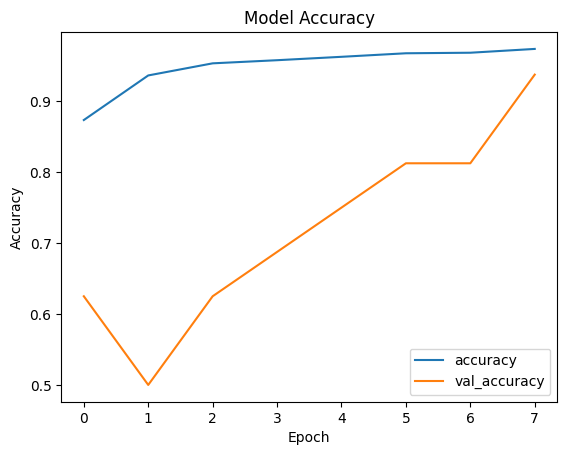

1/1 [==============================] - 0s 24ms/step


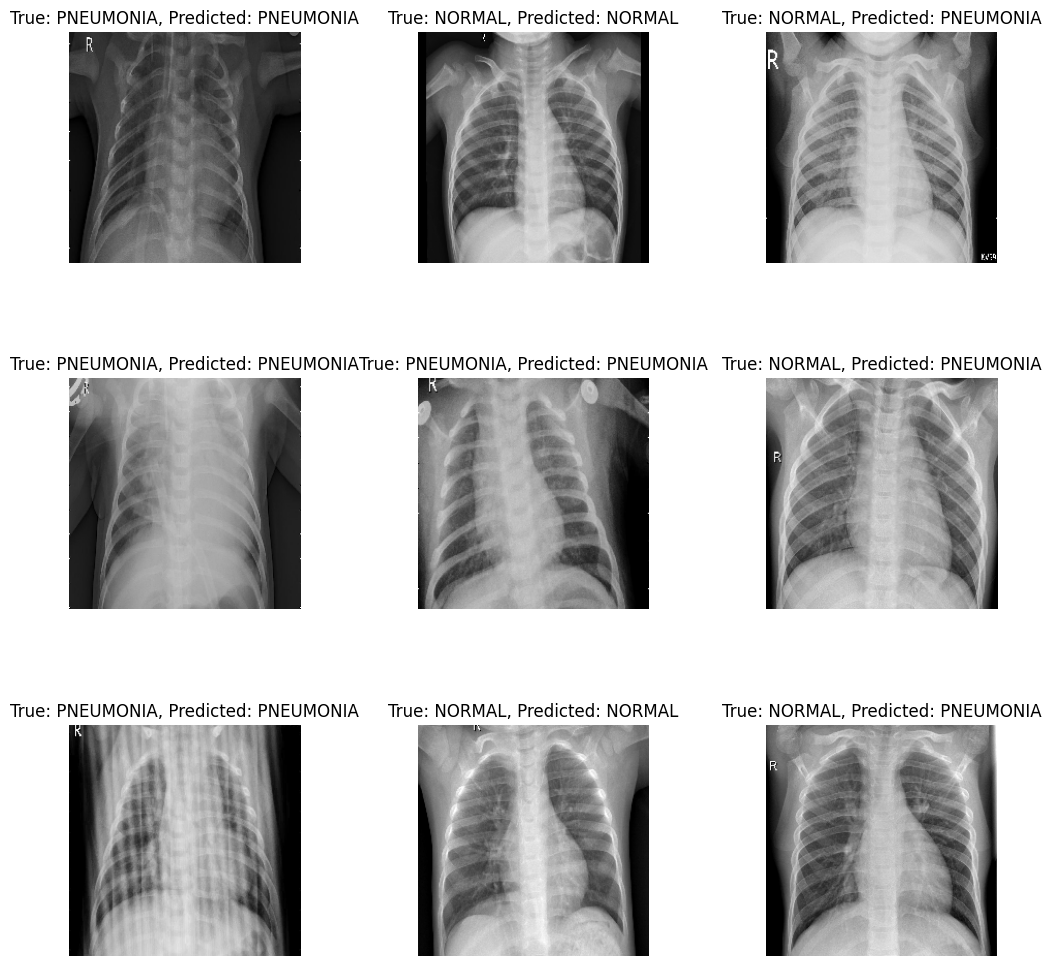

In [22]:
# Plotting accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

# Sample predictions
sample_images, sample_labels = next(test_gen)
predictions = model.predict(sample_images)

# Convert one-hot encoded labels to class names
class_names = list(train_gen.class_indices.keys())
predicted_labels = [class_names[np.argmax(pred)] for pred in predictions]
true_labels = [class_names[np.argmax(label)] for label in sample_labels]

# Plot sample images with true and predicted labels
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust the spacing

for i, ax in enumerate(axes.flat):
    # Normalize the pixel values
    normalized_image = sample_images[i] / 255.0
    ax.imshow(normalized_image)
    ax.set_title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
    ax.axis('off')

plt.show()

